# Evaluation of the model

In [1]:
import os
import csv
import pickle
import numpy as np
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random
import datetime
import scipy.stats as sp 
from matplotlib import cm

In [2]:
log_dir = "./log" 
FIGSIZE = (15,9)
LW = 3
plt.rcParams.update({'font.size': 22})

In [3]:
def plot_performance(means,stds,X=None,names=None,title="",ylabel="performance", minimum = -np.inf, maximum=np.inf,
                     log=False, double =False, xlabel="learning episodes"):
    if names is None:
        names = [str(j) for j in range(len(means))]
    compute_X = (X is None)
    if len(means)<5:
        ncol = [1,1,2,2,2][len(means)] 
    else:
        ncol = len(means)//2
    fig, ax = plt.subplots(figsize=FIGSIZE)
    colors = ['crimson','royalblue','forestgreen','darkorange','orchid']
    handles = []
    for i in range(len(means)):
        if (double and i>=len(means)/2):
            linestyle = ":"
            color = colors[i%(len(means)//2)]
        else:
            linestyle = "-"
            color = colors[i%len(colors)]
        
        mean, std = np.array(means[i]), np.array(stds[i])
        mean_p_std = np.minimum(mean+std, maximum)
        mean_m_std = np.maximum(mean-std, minimum)
        
        if compute_X:
            X = [x for x in range(len(mean))]
        plt.plot(X,mean, color = color,lw=LW, linestyle=linestyle)
        ax.fill_between(X,mean_p_std , mean_m_std, color= color, alpha=0.15)
        plt.plot(X, mean_p_std, color=color, alpha=0.2)
        plt.plot(X, mean_m_std, color=color, alpha=0.2)
        handles.append( mlines.Line2D([], [], color = color, linestyle=linestyle, label= names[i]))
    if log:
        plt.yscale("log")
        if (X[1]-X[0])!=(X[-1]-X[-2]):
            plt.xscale("log")
    else:
        if minimum != -np.inf and maximum!=np.inf:
            plt.ylim(minimum,maximum)
        elif minimum != -np.inf:
            plt.ylim(minimum)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(handles=handles, numpoints = 2, loc="center left",ncol=ncol,bbox_to_anchor=(0., 1.07))
    plt.show()

## Rewards prediction

In [75]:
def confusion_matrix(subdirs, data, iterations):
    def analyze_confusion_matrix(conf_matrix):
        [[TN,FN],[FP,TP]] = conf_matrix
        TPR = TP/(TP+FN) if (TP +FN) !=0 else 0
        TNR = TN/(TN+FP) if (FP +TN) !=0 else 0
        ACC = (TP+TN)/(TP+TN+FP+FN) if (TP+TN+FP+FN) !=0 else 0
        Precision = TP/(TP+FP) if (TP+FP) !=0 else 0
        FS = 2*TP/(2*TP+FP+FN) if (2*TP+FP+FN) !=0 else 0
        return [TPR,TNR,ACC,Precision,FS]
    
    tasks_group =[[0,1,2,3],
                  [4,6,7,8,9,26,14,27] , 
                  [5,10,11,12,13,28,15,29], 
                  [16,18,19,20,21],
                  [17,22, 23,24,25]]

    group_legend = ['Hand', 
                    'Left Stick',
                    'Right Stick',
                    'Magnet',
                    'Scratch']

    rates_names = ['Recall','True Negative Rate','Accuracy','Precision','F1 Score']
    color = ['blueviolet']+['royalblue']+['crimson']+['darkgreen']+['orange']
        
    Rates = []
    Rates_error = []

    for it in range(iterations):
        filename = ['confusion_matrix_evaluation_data_'+str(it)+'.pk','confusion_matrix_'+str(it)+'.pk'][data]
        rates_mean = []
        test = []
        for model in subdirs:
            with open(model+'/'+filename,'br')as f:
                conf_matrix = pickle.load(f)
            if data == 1:
                rates = [[] for _ in range(5)]
                for group in tasks_group:
                    res = analyze_confusion_matrix(np.mean(conf_matrix[group],axis=0))
                    for i in range(5):
                        rates[i].append(res[i])
                rates_mean.append(rates)
            else:
                for b in range(len(conf_matrix)):
                    rates = [[] for _ in range(5)]
                    for group in tasks_group:
                        res = analyze_confusion_matrix(np.mean(conf_matrix[b][group],axis=0))
                        for i in range(5):
                            rates[i].append(res[i])
                    rates_mean.append(rates)
        
        Rates.append(np.mean(rates_mean, axis=0))
        Rates_error.append(np.std(rates_mean, axis=0))

    Rates = np.array(Rates)
    Rates_error = np.array( Rates_error)
    for rate in range(5):
        fig,axarr = plt.subplots(1,1, sharex=True,figsize=(16,9))
        plt.subplot(111)

        for g in range(5):
            plt.plot(Rates[:,rate,g], c=color[g], label=group_legend[g])
        plt.title(rates_names[rate])
        plt.legend()
        plt.ylim((0,1))
        

    plot_performance([np.mean(Rates[:,4], axis=1)], [np.mean(Rates_error[:,4], axis=1)],
                    minimum=0, maximum=1, title="Rewards prediction", 
                    ylabel="F1 Score", xlabel="iterations")


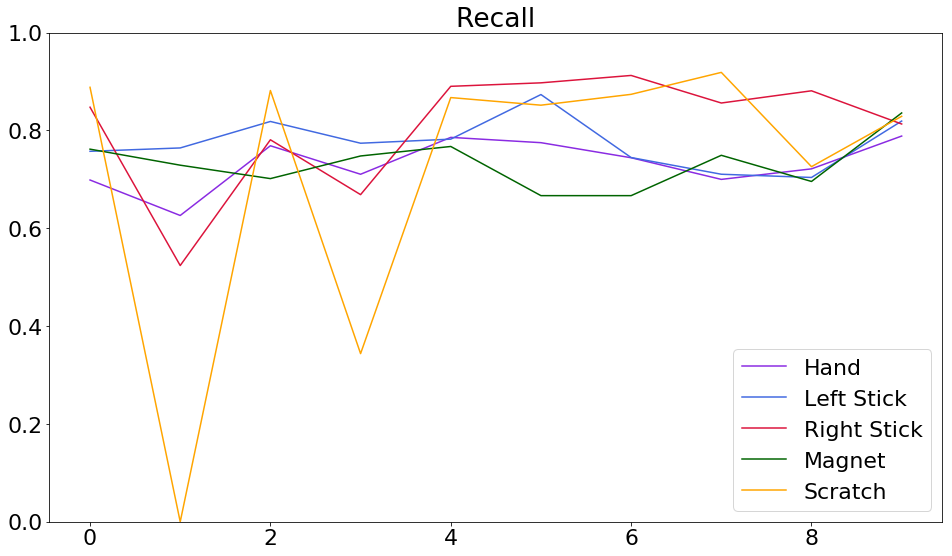

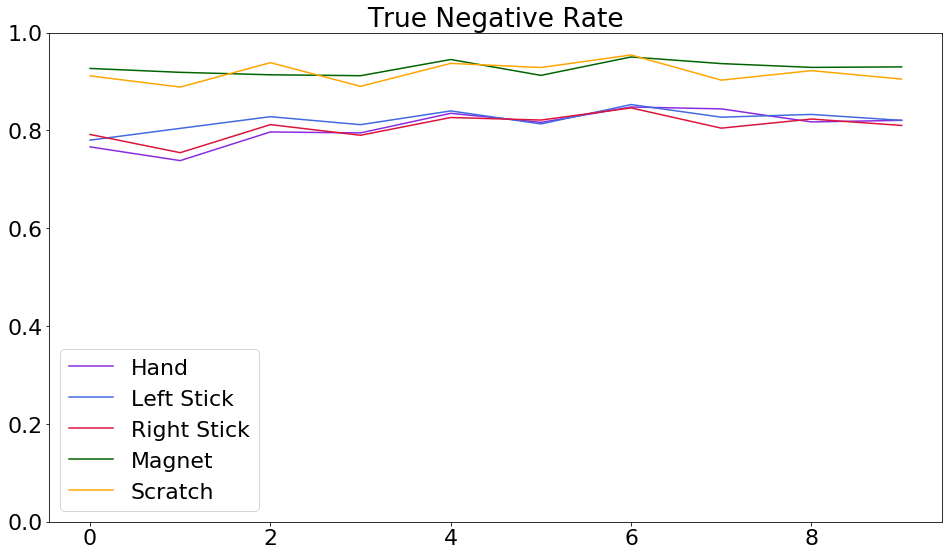

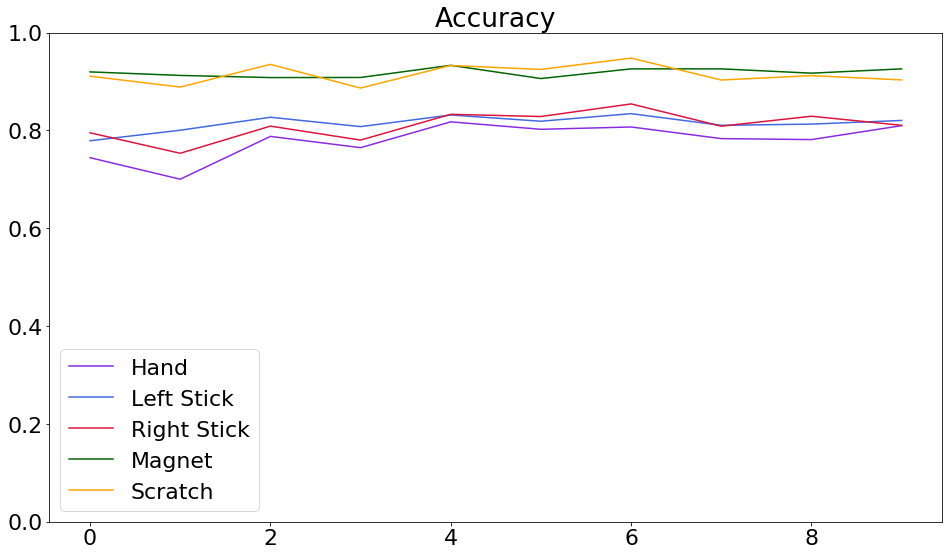

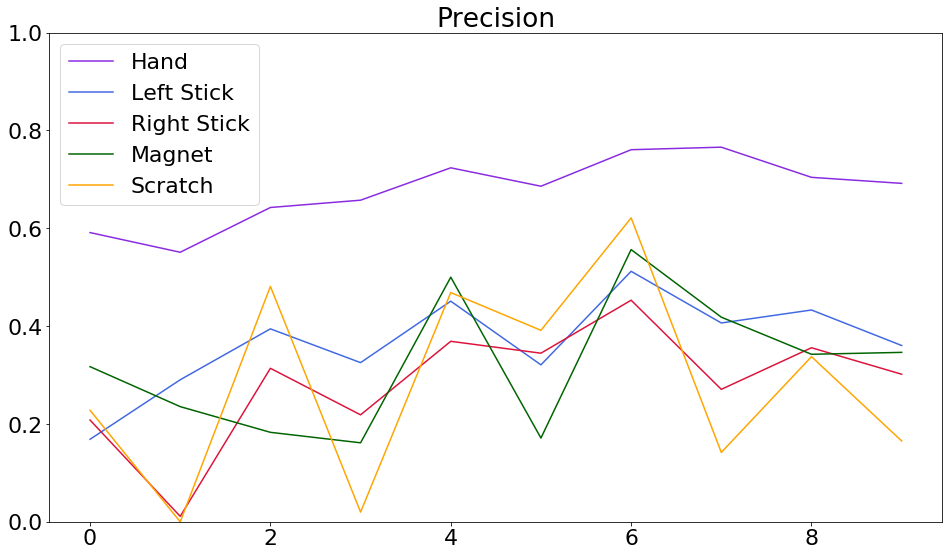

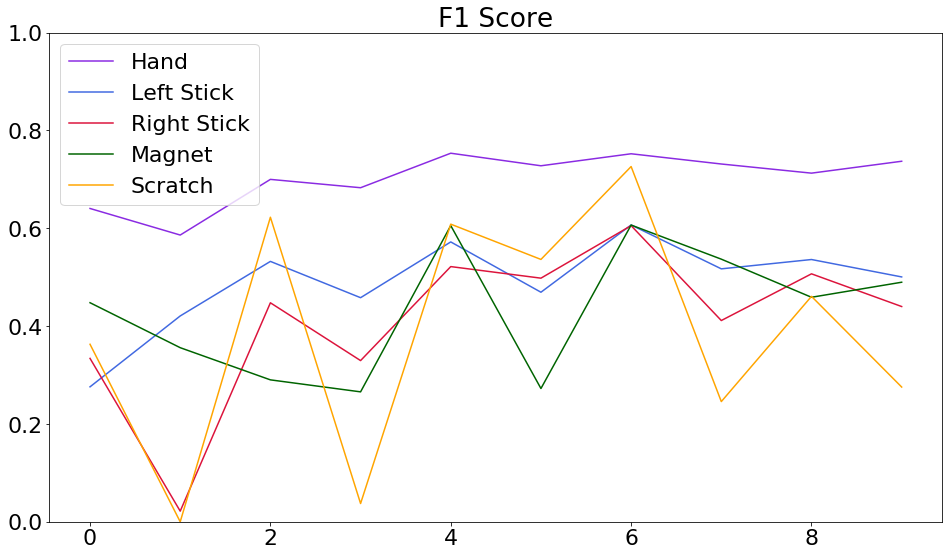

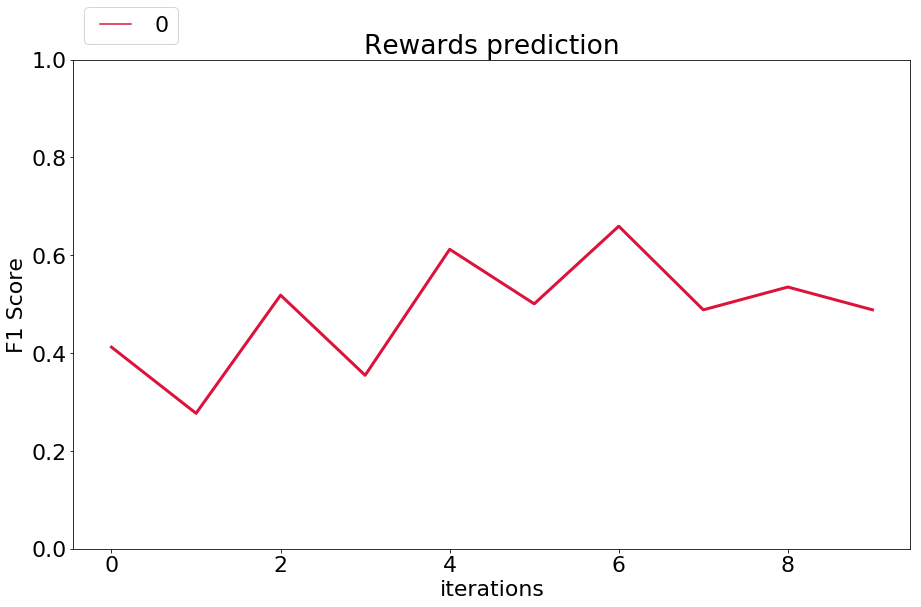

In [76]:
model = "/home/tim/Documents/stage-m2/tf_test/log/2019-05-14 16:25:08.634301"

confusion_matrix([model], data=0, iterations=10)